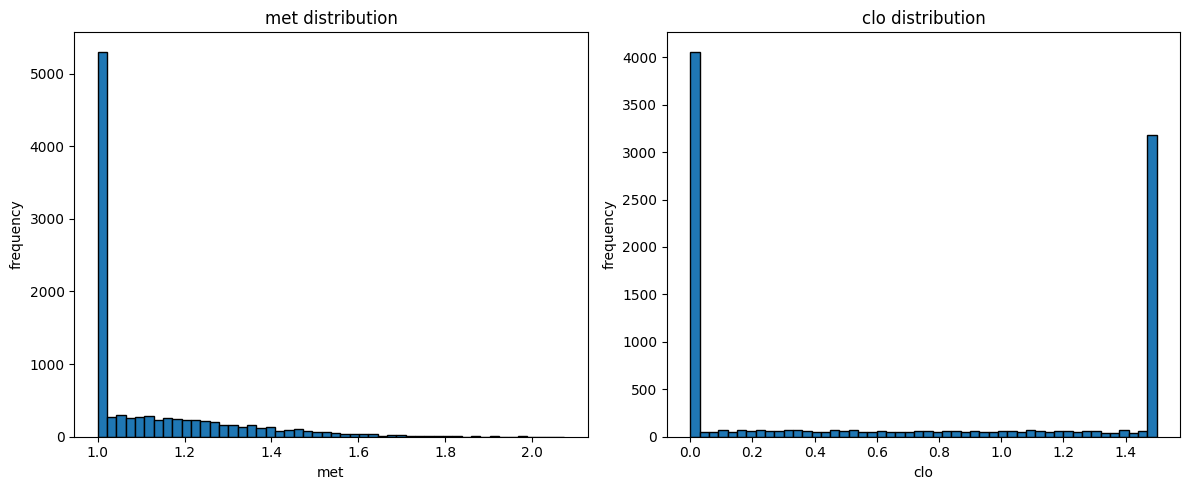

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_distribution(met_mu, met_sigma, clo_mu, clo_sigma, n_samples=10000):
    met_samples = np.clip(np.random.normal(met_mu, met_sigma, n_samples), 1, 4)
    clo_samples = np.clip(np.random.normal(clo_mu, clo_sigma, n_samples), 0, 1.5)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.hist(met_samples, bins=50, edgecolor='black')
    ax1.set_title('met distribution')
    ax1.set_xlabel('met')
    ax1.set_ylabel('frequency')

    ax2.hist(clo_samples, bins=50, edgecolor='black')
    ax2.set_title('clo distribution')
    ax2.set_xlabel('clo')
    ax2.set_ylabel('frequency')

    plt.tight_layout()
    plt.show()

plot_distribution(met_mu=1, met_sigma=0.3, clo_mu=0.5, clo_sigma=2)

The linear translation assumes that the underlying distributions are normal (Gaussian) and that the relationship between the original and new environments can be captured by a linear transformation

In [20]:
import math
import numpy as np
from datetime import timedelta
import gym
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Opions 1
# linear translation class
# The idea being since the transformation is linear it keeps the relative differences between values within the same variables?
class LinearTranslation(gym.Env):
    def __init__(self, original_env, new_env):
        self.original_env= original_env
        self.new_env= new_env

    def translate(self, obs):
        translated_obs= obs.copy()
        translated_obs['met'] = self.translate_met(obs['met'])
        translated_obs['clo'] = self.translate_clo(obs['clo'])
        return translated_obs
    
    def translate_met(self, met):
        return (met - self.new_env['met_mu']) / self.new_env['met_sigma'] * \
               self.original_env['met_sigma'] + self.original_env['met_mu']

    def translate_clo(self, clo):
        return (clo - self.new_env['clo_mu']) / self.new_env['clo_sigma'] * \
               self.original_env['clo_sigma'] + self.original_env['clo_mu']

# Opions 2
# kde transform
# kde-based translation can handle non-linear relationships between the original and new distributions. This makes sense iaf the new environment data does not follow a normal distribution or if the distributions have differentshapes
class KDETranslation(gym.Env):
    def __init__(self, original_env , new_env):
        self.original_env = original_env
        self.new_env= new_env
        self.kde_met = None
        self.kde_new_met = None
        self.kde_clo = None
        self.kde_new_clo = None
        
    def fit(self, original_data, new_data):
        self.kde_original_met = gaussian_kde(original_data['met'])
        self.kde_new_met = gaussian_kde(new_data['met'])
        self.kde_original_clo = gaussian_kde(original_data['clo'])
        self.kde_new_clo = gaussian_kde(new_data['clo'])

    def translate(self, obs):
        translated_obs= obs.copy()
        translated_obs['met'] = self.translate_met(obs['met'])
        translated_obs['clo'] = self.translate_clo(obs['clo'])
        return translated_obs
    
    def translate_met(self, met):
        return self.kde_transform(self.kde_original_met, self.kde_new_met, met)

    def translate_clo(self, clo):
        return self.kde_transform(self.kde_original_clo, self.kde_new_clo, clo)

    def kde_transform(self, kde_original, kde_new, x):
        cdf_value = kde_new.integrate_box_1d(-np.inf, x)
        return kde_original.ppf(cdf_value)

### Kolmogorov-Smirnov (KS) Test
Lower value and higher p-value indicate more similar distributions

### Kullback-Leibler (KL) Divergence
Lower values indicate more similar distributions

### Mean Absolute Error (MAE)
Lower value indicate less average difference between original and translated values

In [19]:
from scipy import stats

def generate_data(params, n_samples):
    return {
        'met': np.random.normal(params['met_mu'], params['met_sigma'], n_samples),
        'clo': np.random.normal(params['clo_mu'], params['clo_sigma'], n_samples)
    }

def evaluate_translation(original, translated, method_name):
    ks_statistic, p_value = stats.ks_2samp(original, translated)
    kl_divergence = stats.entropy(stats.gaussian_kde(original)(original), stats.gaussian_kde(translated)(original))
    print(f"{method_name} Translation Evaluation:")
    print(f"KS Test - statistic: {ks_statistic:.4f}, p-value: {p_value:.4f}")
    print(f"KL Divergence: {kl_divergence:.4f}")
    print(f"Mean Absolute Error: {np.mean(np.abs(original - translated)):.4f}")
    print()

# random parameters
original_params = {
    'met_mu': 1.2, 'met_sigma': 0.2,
    'clo_mu': 0.5, 'clo_sigma': 0.1,
}

new_params = {
    'met_mu': 1.5, 'met_sigma': 0.3,
    'clo_mu': 0.7, 'clo_sigma': 0.15,
}

num = 100
original_data = generate_data(original_params, num)
new_data = generate_data(new_params, num)

linear_translator = LinearTranslation(original_params, new_params)
kde_translator = KDETranslation(original_params, new_params)
kde_translator.fit(original_data, new_data)

# comparing the new translated values to the original
linear_met = np.array([linear_translator.translate_met(x) for x in new_data['met']])
linear_clo = np.array([linear_translator.translate_clo(x) for x in new_data['clo']])

kde_met = np.array([kde_translator.translate_met(x) for x in new_data['met']])
kde_clo = np.array([kde_translator.translate_clo(x) for x in new_data['clo']])

print("Metabolic Rate:")
evaluate_translation(original_data['met'], linear_met, "Linear")
evaluate_translation(original_data['met'], kde_met, "KDE")

print("Clothing Insulation:")
evaluate_translation(original_data['clo'], linear_clo, "Linear")
evaluate_translation(original_data['clo'], kde_clo, "KDE")

Metabolic Rate:
Linear Translation Evaluation:
KS Test - statistic: 0.0550, p-value: 0.9238
KL Divergence: 0.0064
Mean Absolute Error: 0.2355

KDE Translation Evaluation:
KS Test - statistic: 0.0300, p-value: 1.0000
KL Divergence: 0.0012
Mean Absolute Error: 0.2362

Clothing Insulation:
Linear Translation Evaluation:
KS Test - statistic: 0.1000, p-value: 0.2705
KL Divergence: 0.0189
Mean Absolute Error: 0.1159

KDE Translation Evaluation:
KS Test - statistic: 0.0500, p-value: 0.9647
KL Divergence: 0.0016
Mean Absolute Error: 0.1195

